# Practical Work: Reinforcement Learning
## Part 1: Solving the CartPole environment
We will use [OpenAI Gym](https://gym.openai.com/) simulators to practice.  
Please read the [introduction document](https://gym.openai.com/docs/) to __Gym__. 

## I - CartPole

This is the robotic classic [inverted pendulum problem](https://en.wikipedia.org/wiki/Inverted_pendulum).  
- [About the CartPole environment](https://github.com/openai/gym/wiki/CartPole-v0)
- [CartPole Leaderboard](https://github.com/openai/gym/wiki/Leaderboard#cartpole-v0)
- [OpenAI Requests for Research](https://openai.com/requests-for-research/#cartpole)

### Description
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson 

### Environment Observation

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

### Environment Actions

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right

### Reward
Reward is 1 for every step taken, including the termination step

### Starting State
All observations are assigned a uniform random value between ±0.05

### Episode Termination
- Pole Angle is more than ±12°
- Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 200

### Solved Requirements
Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

## 1- Try to play by yourself!

In [74]:
import gym
from gym.envs.classic_control.cartpole import *
from pyglet.window import key
import matplotlib.pyplot as plt
import time

bool_do_not_quit = True  # Boolean to quit pyglet
scores = []  # Your gaming score
a = 0  # Action

def key_press(k, mod):
    global bool_do_not_quit, a, restart
    if k==0xff0d: restart = True
    if k==key.ESCAPE: bool_do_not_quit=False  # Added to Quit
    if k==key.Q: bool_do_not_quit=False  # Added to Quit
    if k==key.LEFT:  a = 0  # 0	Push cart to the left
    if k==key.RIGHT: a = 1  # 1	Push cart to the right

def run_cartPole_asHuman(policy=None, record_video=False):
    env = CartPoleEnv()

    env.reset()
    env.render()
    if record_video:
        env.monitor.start('/tmp/video-test', force=True)
    env.viewer.window.on_key_press = key_press

    while bool_do_not_quit:
        env.reset()
        total_reward = 0.0
        steps = 0
        restart = False
        t1 = time.time()  # Trial timer
        while bool_do_not_quit:
            s, r, done, info = env.step(a)
            time.sleep(1/10)  # 10fps: Super slow for us poor little human!
            total_reward += r
            steps += 1
            if not record_video: # Faster, but you can as well call env.render() every time to play full window.
                env.render()
            if done or restart:
                t1 = time.time()-t1
                scores.append(total_reward)
                print("Trial", len(scores), "| Score:", total_reward, '|', steps, "steps | %0.2fs."% t1)
                break
    env.close()

run_cartPole_asHuman()  # Run with human keyboard input

Trial 1 | Score: 9.0 | 9 steps | 0.96s.
Trial 2 | Score: 11.0 | 11 steps | 1.14s.
Trial 3 | Score: 11.0 | 11 steps | 1.13s.
Trial 4 | Score: 10.0 | 10 steps | 1.04s.
Trial 5 | Score: 9.0 | 9 steps | 0.93s.


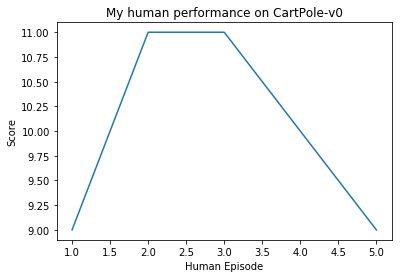

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot your score
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('My human performance on CartPole-v0')
plt.ylabel('Score')
plt.xlabel('Human Episode')
plt.show()

## 2 - Create an Agent to solve the problem

- Hand-crafted conditionnal control
    - Always 0 or Always 1
    - Random action
    - Conditional Statements (If/Else Bang) control on an observed value


- Control theory:
    - PID controller
    - Model Predictive controler


- Reinforcement Learning
    - Random Search
    - Policy Gradient
    - Q-Learning
    - Deep Q-Learning


- More: What you want!

In [5]:
import gym
import numpy as np
# Define the Environments
env = gym.make('CartPole-v0')

# We can customize the environments:
# env.env.theta_threshold_radians = np.pi * 2
# env.env.x_threshold = 5
# env.env.force_mag = 100
# env.env.state[2] = np.pi  # Initial angle state to put after env.reset()

# Set random generator for reproductible runs
env.seed(0)
np.random.seed(0)

# Number of Dimensions in the Observable Space and number of Control Actions in the Environments
print('Observation Space:', env.observation_space)
print('Action Space:', env.action_space)

print("\n")
print("Observation Space Param:   Cart Position|Cart Velocity | Pole Angle | Pole Velocity |", )
print("Observation Space Highs: ", env.observation_space.high)
print("Observation Space Lows: ", env.observation_space.low)

Observation Space: Box(4,)
Action Space: Discrete(2)


Observation Space Param:   Cart Position|Cart Velocity | Pole Angle | Pole Velocity |
Observation Space Highs:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Observation Space Lows:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [6]:
# Run the environment

from collections import deque
import numpy as np
from gym.envs.classic_control.cartpole import *
from pyglet.window import key
import time

bool_quit = False

def key_press(k, mod):
    global bool_quit, action, restart
    if k==0xff0d: restart = True
    if k==key.ESCAPE: bool_quit=True  # Quit properly
    if k==key.Q: bool_quit=True  # Quit properly
    if k==key.LEFT:  action = 0  # 0	Push cart to the left
    if k==key.RIGHT: action = 1  # 1	Push cart to the right

def run_cartPole(policy, n_episodes=1000, max_t=1000, print_every=100, render_env=True, record_video=False):
    """Run the CartPole-v0 environment.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        print_every (int): how often to print average score (over last 100 episodes)
    
    Adapted from:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/hill-climbing/Hill_Climbing.ipynb

    """
    global bool_quit

    if policy.__class__.__name__ == 'Policy_Human':
        global action
        action = 0  # Global variable used for manual control with key_press
        env = CartPoleEnv()  # This is mandatory for keyboard input
        env.reset()  # This is mandatory for keyboard input
        env.render()  # This is mandatory for keyboard input
        env.viewer.window.on_key_press = key_press  # Quit properly & human keyboard inputs
    else:
        print('** Evaluating', policy.__class__.__name__, '**')
        # Define the Environments
        env = gym.make('CartPole-v0')
        # Set random generator for reproductible runs
        env.seed(0)
        np.random.seed(0)

    if record_video:
        env.monitor.start('/tmp/video-test', force=True)

    scores_deque = deque(maxlen=100)
    scores = []
    trials_to_solve=[]

    for i_episode in range(1, n_episodes+1):
        rewards = []
        state = env.reset()
        if 'reset' in dir(policy):  # Check if the .reset method exists
            policy.reset(state)
        for t in range(max_t):  # Avoid stucked episodes
            action = policy.act(state)
            state, reward, done, info = env.step(action)
            rewards.append(reward)
            if 'memorize' in dir(policy):  # Check if the .memorize method exists
                policy.memorize(state, action, reward, done)
            if render_env: # Faster, but you can as well call env.render() every time to play full window.
                env.render()  # (mode='rgb_array')  # Added  # Changed mode

            if done:  # if Pole Angle is more than +-12 deg or Cart Position is more than +-2.4 (center of the cart reaches the edge of the display) the simulation ends
                trials_to_solve.append(t)
                break

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        if 'update' in dir(policy):  # Check if the .update method exists
            policy.update(state)  # Update the policy

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}\tSteps: {:d}'.format(i_episode, np.mean(scores_deque), t))
        if np.mean(scores_deque) >= 195.0:
            print('Episode {}\tAverage Score: {:.2f}\tSteps: {:d}'.format(i_episode, np.mean(scores_deque), t))
            print('** Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(max(1, i_episode-100), np.mean(scores_deque)))
            break
        if bool_quit:
            break

    if np.mean(scores_deque) < 195.0:
        print('** The environment has never been solved!')
        print('   Mean scores on all runs was < 195.0')
    if record_video:
        env.env.close()
    env.close()
    return scores, trials_to_solve

In [7]:
#  Performance plots
import matplotlib.pyplot as plt
%matplotlib inline
def plot_performance(scores):
    # Plot the policy performance
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.arange(1, len(scores) + 1)
    y = scores
    plt.scatter(x, y, marker='x', c=y)
    fit = np.polyfit(x, y, deg=4)
    p = np.poly1d(fit) 
    plt.plot(x,p(x),"r--") 
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(policy.__class__.__name__ +  ' performance on CartPole-v0')
    plt.show()

def plot_trials_to_solve(trials_to_solve):
    # Plot the policy number of trials to solve the Environment
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.hist(trials_to_solve, bins='auto', density=True, facecolor='g', alpha=0.75)
    plt.ylabel('Frequency')
    plt.xlabel('Number of Trial to solve')
    plt.title(policy.__class__.__name__ +  ' trials to solve CartPole-v0')
    plt.show()

def plot_weights_history(weights_history):
    weights_history = np.array(weights_history)
    # weights_history[:, 0, 0]  # Cart Pos, Action 0
    # weights_history[:, 1, 0]  # Cart Vel, Action 0
    # weights_history[:, 2, 0]  # Pole Ang, Action 0
    # weights_history[:, 3, 0]  # Pole Vel, Action 0
    plt.figure(0)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=1.6, hspace=.5)
    i = 0
    for obs_id in range(weights_history.shape[1]):  # Loop through Observations
        if len(weights_history.shape) == 3:
            for act_id in range(weights_history.shape[2]):  # Action 0 and Action 1
                plt.subplot(4, 2, i + 1)
                i += 1
                # plt.axis('off')
                plt.plot(weights_history[:, obs_id, act_id])
                plt.title('Obs%d, Act%d' % (obs_id, act_id))
        else:
            plt.subplot(2, 2, i + 1)
            i += 1
            # plt.axis('off')
            plt.plot(weights_history[:, obs_id])
            plt.title('Obs%d' % (obs_id))

### 2.1 - Human keyboard input Policy

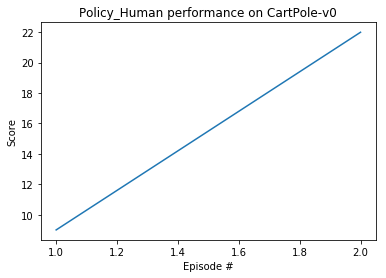

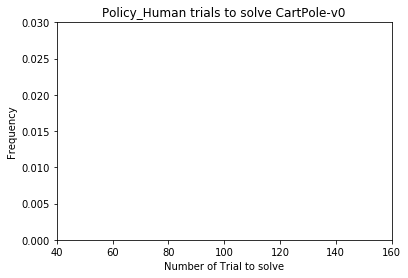

In [89]:
# Define a human keyboard input Policy
import time
class Policy_Human():

    def act(self, state):
        global action  # action is a global variable changed by keyboard input
        time.sleep(1/10)  # 10fps: Super slow for us poor little human!
        return action

policy = Policy_Human()
scores, trials_to_solve = run_cartPole(policy, n_episodes=100, print_every=100, record_video=False)
print('** Mean average score:', np.mean(scores))
plot_performance(scores)

### 2.2 Always the same Policy

** Evaluating Policy_Always0 **
Episode 100	Average Score: 9.40	Steps: 8
Episode 200	Average Score: 9.24	Steps: 8
Episode 300	Average Score: 9.41	Steps: 8
Episode 400	Average Score: 9.27	Steps: 9
Episode 500	Average Score: 9.34	Steps: 9
Episode 600	Average Score: 9.38	Steps: 9
Episode 700	Average Score: 9.37	Steps: 9
Episode 800	Average Score: 9.31	Steps: 8
Episode 900	Average Score: 9.33	Steps: 8
Episode 1000	Average Score: 9.34	Steps: 8
** The environment has never been solved!
   Mean scores on all runs was < 195.0
** Mean average score: 9.339


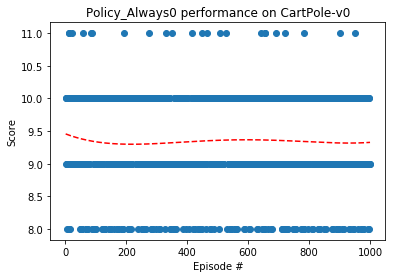

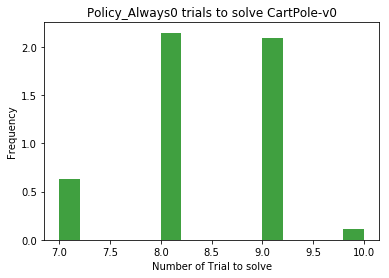

In [11]:
# Define a binary Policy
class Policy_Always0():

    def act(self, state):
        print('** Add your code here **')
        return action

policy = Policy_Always0()
scores, trials_to_solve = run_cartPole(policy, n_episodes=1000, print_every=100, record_video=False)
print('** Mean average score:', np.mean(scores))
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)

### 2.3 Random Policy

** Evaluating Policy_Random **
Episode 100	Average Score: 9.31	Steps: 9
Episode 200	Average Score: 9.47	Steps: 9
Episode 300	Average Score: 9.27	Steps: 9
Episode 400	Average Score: 9.46	Steps: 8
Episode 500	Average Score: 9.38	Steps: 8
Episode 600	Average Score: 9.37	Steps: 8
Episode 700	Average Score: 9.41	Steps: 8
Episode 800	Average Score: 9.37	Steps: 9
Episode 900	Average Score: 9.35	Steps: 9
Episode 1000	Average Score: 9.35	Steps: 9
** The environment has never been solved!
   Mean scores on all runs was < 195.0
** Mean average score: 9.374


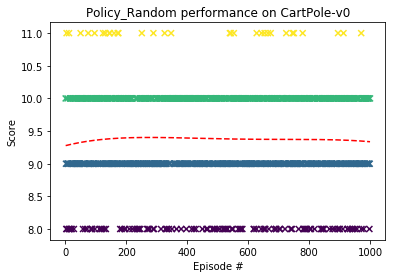

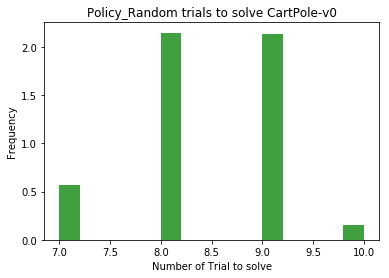

In [13]:
# Define a random Policy
class Policy_Random():

    def act(self, state):
        self.observation = state
        print('** Add your code here **')
        return action

policy = Policy_Random()
scores, trials_to_solve = run_cartPole(policy, n_episodes=1000, print_every=100, record_video=False)
print('** Mean average score:', np.mean(scores))
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)

### 2.4 Conditional statement control Policy

** Evaluating Policy_ConditionalBangControl **
Episode 100	Average Score: 41.43	Steps: 46
Episode 200	Average Score: 42.01	Steps: 29
Episode 300	Average Score: 42.02	Steps: 57
Episode 400	Average Score: 41.94	Steps: 33
Episode 500	Average Score: 41.99	Steps: 37
Episode 600	Average Score: 42.34	Steps: 45
Episode 700	Average Score: 41.56	Steps: 46
Episode 800	Average Score: 42.27	Steps: 45
Episode 900	Average Score: 40.70	Steps: 37
Episode 1000	Average Score: 42.20	Steps: 36
** The environment has never been solved!
   Mean scores on all runs was < 195.0


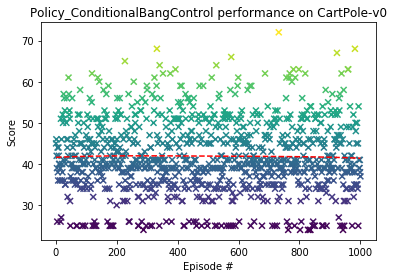

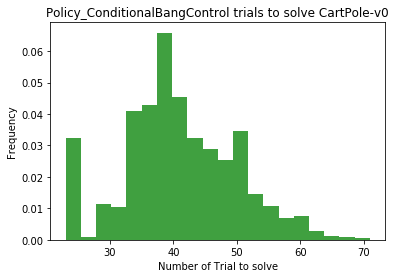

In [14]:
# Define a conditional statment control Policy on the Angle
class Policy_ConditionalBangControl():
    def __init__(self):
        self.action = 0

    def act(self, state):
        self.observation_angle = state[2]  # This is the observed pole angle
        print('** Add your IF/ELSE code here **)
        return self.action

policy = Policy_ConditionalBangControl()
scores, trials_to_solve = run_cartPole(policy, n_episodes=1000, print_every=100, record_video=False)
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)

In [15]:
class Policy_AdvancedConditionalBangControl():
    def __init__(self):
        self.action = 0

    def act(self, state):
        self.observation_angle = state[2]  # This is the observed pole angle
        self.observation_pole_vel = state[3]  # This is the observed pole velocity
        print('** Add your hacky solution here **')
        return action

policy = Policy_AdvancedConditionalBangControl()
scores, trials_to_solve = run_cartPole(policy, n_episodes=1000, print_every=100, record_video=False)

** Evaluating Policy_AdvancedConditionalBangControl **
Episode 1	Average Score: 200.00	Steps: 199
** Environment solved in -99 episodes!	Average Score: 200.00


### 2.5 PID controler Policy

** Evaluating Policy_PID **
Episode 100	Average Score: 9.27	Steps: 8
Episode 200	Average Score: 9.34	Steps: 8
Episode 300	Average Score: 9.21	Steps: 10
Episode 400	Average Score: 9.30	Steps: 8
Episode 500	Average Score: 9.24	Steps: 8
Episode 600	Average Score: 9.44	Steps: 10
Episode 700	Average Score: 9.57	Steps: 8
Episode 800	Average Score: 9.53	Steps: 10
Episode 900	Average Score: 9.39	Steps: 10
Episode 1000	Average Score: 9.64	Steps: 8
** The environment has never been solved!
   Mean scores on all runs was < 195.0
** Mean average score: 9.393


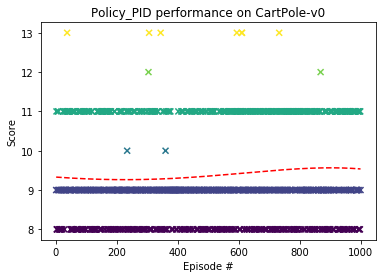

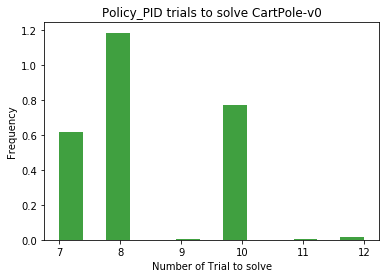

Absolute PID controller Error sum: 38310.63818365861
Absolute PID controller Force sum: 9393


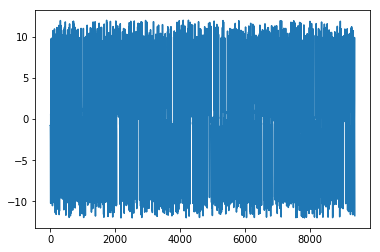

In [16]:
# TODO: Machine Learning to find the PID controller coefficients

# Original code from http://www.inf.u-szeged.hu/~szepet/python/pend_continuous.py
from simple_pid import PID

# Define an PID control Policy
class Policy_PID():
    def __init__(self):
        self.action = 0

        self.log_err = [] # Log the error signal
        self.abs_force_sum = 0

        self.pars = [-1000, -1, 0.1]  # TODO: How could we learn those parameters? [0.3, 0.01, 0.1]
        self.setpoint = 0;
        self.pid = PID(
            self.pars[0], self.pars[1], self.pars[2], self.setpoint)
        self.pid.output_limits = (-1, 1) # Limit output to the range of action space

        # New output will only be calculated when sample_time seconds has passed
        self.pid.sample_time = 0.00001 # WARNING: This is not depended to the env.state! Only CPU time..

    def act(self, state):
        self.cartpos = state[0] # position of the cart
        self.observation_angle_rad = state[2] * (180 / np.pi) # angle of the pole

        # Error calculation
        err = self.setpoint - self.observation_angle_rad
        self.log_err.append(err) # log the error for visualization

        force_k = self.pid(err);
        self.abs_force_sum += np.absolute(force_k)
        if force_k > 0:
            return 1
        else:
            return 0


policy = Policy_PID()
scores, trials_to_solve = run_cartPole(policy, n_episodes=1000, print_every=100, record_video=False)

print('** Mean average score:', np.mean(scores))
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)

abs_error_sum = np.sum(np.absolute(policy.log_err))
print('Absolute PID controller Error sum:', abs_error_sum)
print('Absolute PID controller Force sum:', policy.abs_force_sum)
plt.plot(policy.log_err)
plt.show()

### 2.6 MPC Policy

In [17]:
# Orginal code from http://www.philipzucker.com/model-predictive-control-of-cartpole-in-openai-gym-using-osqp/
from mpc import MPC  # Author: Philip Zucker
# Resources on MPC:
# http://www.philipzucker.com/osqp-sparsegrad-fast-model-predictive-control-python-inverted-pendulum/
# https://github.com/philzook58/cart_pole  # RL on a Real Cart Pole

# Define an MPC control Policy based on the sparsegrad and osqp solver packages
class Policy_MPC():
    def __init__(self):
        self.action = 0

        start_theta = np.pi  #  -np.pi + 0.4  # + 0.1  # 2 * np.pi  # np.pi+0.4
        self.mpc = MPC(0.5, 0, start_theta, 0) 

    def act(self, state):
        self.action = self.mpc.update(state[0] + 0.5, state[1], state[2] + np.pi, state[3])
        if self.action < 0:
            return 0
        return 1

policy = Policy_MPC()
scores, trials_to_solve = run_cartPole(policy, n_episodes=1000, print_every=1, record_video=False)

print('** Mean average score:', np.mean(scores))
# plot_performance(scores)
# plot_trials_to_solve(trials_to_solve)
print(policy.mpc.calcQ())

/Users/Pierre/.virtualenvs/DeepQC/lib/python3.6/site-packages/osqp/interface.py:109: UserWarning: Converting sparse P to a CSC (compressed sparse column) matrix. (It may take a while...)
  "(compressed sparse column) matrix. (It may take a while...)")


** Evaluating Policy_MPC **
Episode 1	Average Score: 200.00	Steps: 199
Episode 1	Average Score: 200.00	Steps: 199
** Environment solved in -99 episodes!	Average Score: 200.00
** Mean average score: 200.0
[ -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
  -0.025       -0.025       -0.025       -0.025       -0.025
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.       

## 3 - Reinforcement Learning

### 3.1 Random Search Policy

** Evaluating Policy_RandomSearch **
Episode 100	Average Score: 49.57	Steps: 139
Episode 200	Average Score: 57.20	Steps: 199
Episode 300	Average Score: 45.32	Steps: 29
Episode 400	Average Score: 48.37	Steps: 43
Episode 500	Average Score: 32.31	Steps: 111
Episode 600	Average Score: 49.27	Steps: 9
Episode 700	Average Score: 51.34	Steps: 37
Episode 800	Average Score: 48.24	Steps: 8
Episode 900	Average Score: 48.24	Steps: 17
Episode 1000	Average Score: 45.25	Steps: 8
** The environment has never been solved!
   Mean scores on all runs was < 195.0
** Best reward recorded: 199
** Best parameters  **
  Cart Position coef: -0.925577927382397
  Cart Velocity coef: 0.9867559873798102
  Pole Angle coef:    -0.4512634198247374
  Pole Velocity coef: 0.9044972441434123
** Mean average score: 47.511


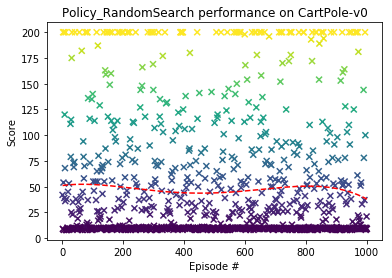

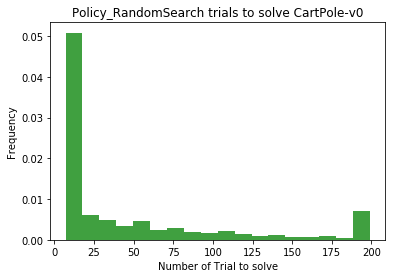

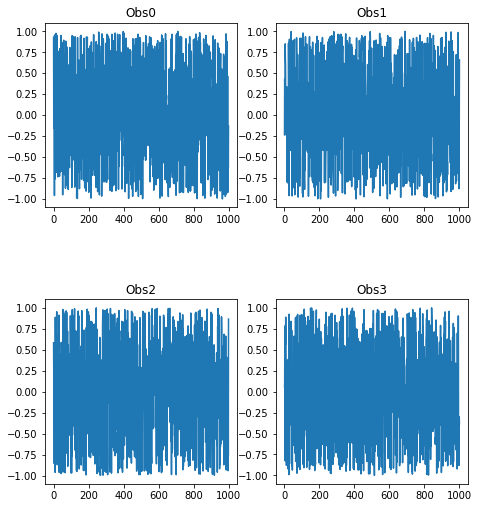

In [61]:
# Define a Random Search Policy
# Find a double PD controller (pos, vel) on both Angle and Translation by randomly trying values.

# from https://github.com/NHDaly/jupyter-binder/blob/master/OpenAI-gym-cartpole-random-guessing.ipynb
def random_range(a, b, shape):
    return (b-a) * np.random.random(shape) + a

class Policy_RandomSearch():
    def __init__(self):
        self.best_parameters = None
        self.best_reward = 0  # or -np.Inf is better?
        self.current_reward = 0
        self.rewards = []
        self.parameters = '** Generate random parameters here **'
        self.parameters_history = [self.parameters]  # History of weights, for viz purpose

    def act(self, state):
        self.observation = state  # This is the observed angle
        action = 0 if np.matmul(self.parameters, self.observation) < 0 else 1
        return action

    def memorize(self, next_state, action, reward, done):
        if reward == 1:
            self.current_reward += 1
        self.rewards.append(self.current_reward)

    def update(self, state):
        self.current_reward = 0
        # We remember the best parameters if the environment was solved
        # TODO: best_reward should be a moving average on some trials to avoid random lucky solution
        if len(self.rewards) > 1 and self.rewards[-1] >= self.best_reward:  # If we have some rewards
            self.best_reward = self.rewards[-1]
            self.best_parameters = self.parameters

        # Get new random parameter values
        self.parameters = '** Generate random parameters here **'
        self.parameters_history.append(self.parameters)

policy = Policy_RandomSearch()

scores, trials_to_solve = run_cartPole(policy, n_episodes=1000, print_every=100, render_env=False, record_video=False)
print('** Best reward recorded:',  policy.best_reward)
print('** Best parameters  **')
print('  Cart Position coef:', policy.best_parameters[0])
print('  Cart Velocity coef:', policy.best_parameters[1])
print('  Pole Angle coef:   ', policy.best_parameters[2])
print('  Pole Velocity coef:', policy.best_parameters[3])
print('** Mean average score:', np.mean(scores))
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)
plot_weights_history(policy.parameters_history)

In [66]:
policy.parameters = policy.best_parameters
# Try the best parameters found:
scores, trials_to_solve = run_cartPole(policy, n_episodes=1, print_every=1, record_video=False)

** Evaluating Policy_RandomSearch **
Episode 1	Average Score: 200.00	Steps: 199
Episode 1	Average Score: 200.00	Steps: 199
** Environment solved in -99 episodes!	Average Score: 200.00


### 3.2 Hill-climbing Policy

- [Udacity DeepRL Hill-climbing](https://github.com/udacity/deep-reinforcement-learning/tree/master/hill-climbing)
- [Kevin Frans' Simple Algorithms for solving CartPole](http://kvfrans.com/simple-algoritms-for-solving-cartpole/)

In [39]:
%%html
<img "Kevin Frans' CartPole hill climbing schema" src="cartpole-hill.jpg" width="600">

** Evaluating Policy_Hill_Climbing **
Episode 100	Average Score: 89.97	Steps: 199
Episode 168	Average Score: 196.20	Steps: 199
** Environment solved in 68 episodes!	Average Score: 196.20
** Mean average score: 134.50595238095238


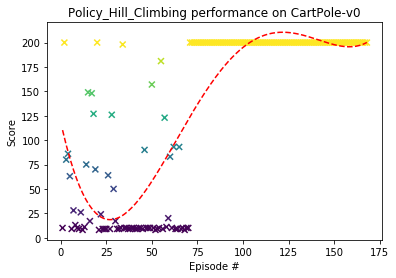

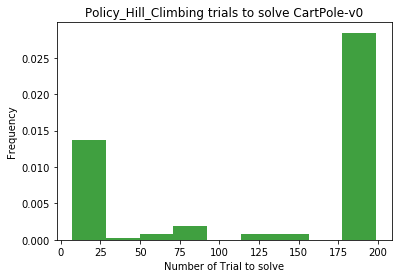

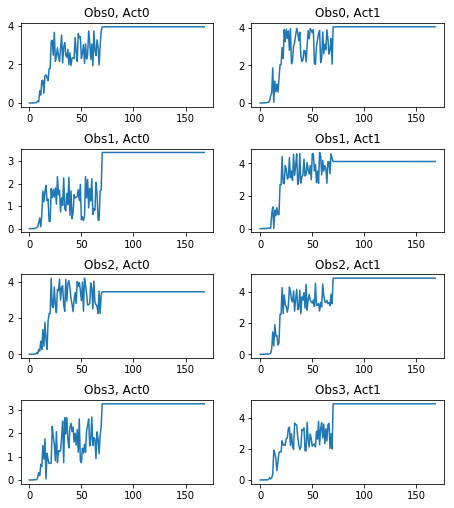

In [67]:
# Define a hill_climbing Policy
class Policy_Hill_Climbing():
    def __init__(self, state_space_dim=4, action_space_dim=2):
        self.rewards = []
        self.best_R = -np.Inf
        # Weights for a simple linear policy:
        self.w = 1e-4 * '** Generate random Weights here **'  # state_space_dim * action_space_dim
        self.best_w = self.w  # Initialize the best weights
        self.w_history = [self.w]  # History of weights, for viz purpose

        self.noise_scale=1e-2  # Standard Deviation of the Additive Noise
        self.gamma=1.0  # discount rate

    def forward(self, state):
        x = np.dot(state, self.w)
        return np.exp(x) / sum(np.exp(x))

    def act(self, state):
        probs = self.forward(state)
        # action = np.random.choice(2, p=probs) # Option 1: Stochastic Policy
        action = np.argmax(probs)               # Option 2: Deterministic Policy
        return action

    def memorize(self, next_state, action, reward, done):
        self.rewards.append(reward)

    def update(self, state):
        discounts = [self.gamma**i for i in range(len(self.rewards)+1)]
        self.R = sum([a*b for a,b in zip(discounts, self.rewards)])

        if self.R >= self.best_R: # found better weights
            self.best_R = self.R
            self.best_w = self.w
            self.noise_scale = max(1e-3, self.noise_scale / 2)
            self.w += '** Add something the Weights here **' * np.random.rand(*self.w.shape) 
        else: # did not find better weights
            self.noise_scale = min(2, self.noise_scale * 2)
            self.w = self.best_w + '** Add something the the Best Weights here **' * np.random.rand(*self.w.shape)

        self.w_history.append(self.w)
        # Reset rewards memory?
        self.rewards = []

policy = Policy_Hill_Climbing()
scores, trials_to_solve = run_cartPole(policy, print_every=100, render_env=False)
print('** Mean average score:', np.mean(scores))
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)
plot_weights_history(policy.w_history)

In [87]:
# Replay with the last trained Policy
# import time
env = gym.make('CartPole-v0')
env = gym.wrappers.Monitor(env, "./gym-results", force=True)  # video_callable=lambda episode_id: True
state = env.reset()
for t in range(200):
    action = policy.act(state)
    # env.render()
    # time.sleep(0.04)  # 25fps
    state, reward, done, _ = env.step(action)
    if done:
        break
env.env.close()  # This was a pain to found!
env.close()  # TODO: Why both env.env.close & env.close?!

In [88]:
# https://stackoverflow.com/a/54149154
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="640" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

### 3.4 Policy Gradient

### 3.5 Q-Learning
Off-policy TD control. Finds the optimal greedy policy while following an epsilon-greedy policy
#### Resources
- [Q-Learning on Wikipedia](https://en.wikipedia.org/wiki/Q-learning)
- [Matthew Chan's Cart-Pole Balancing with Q-Learning](https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947)
- [Ferdinand Mütsch's CartPole with QLearning](https://ferdinand-muetsch.de/cartpole-with-qlearning-first-experiences-with-openai-gym.html)
- [Denny Britz's Q-Learning code](https://github.com/dennybritz/reinforcement-learning/blob/master/TD/Q-Learning%20Solution.ipynb)

![Q-Learning equation on Wikipedia](Q-Learning.svg "Q-Learning equation on Wikipedia")

** Evaluating Policy_QLearning **
Episode 100	Average Score: 60.33	Steps: 15
Episode 200	Average Score: 128.62	Steps: 199
Episode 300	Average Score: 179.22	Steps: 199
Episode 400	Average Score: 192.17	Steps: 199
Episode 415	Average Score: 195.95	Steps: 199
** Environment solved in 315 episodes!	Average Score: 195.95
** Mean average score: 142.25060240963856


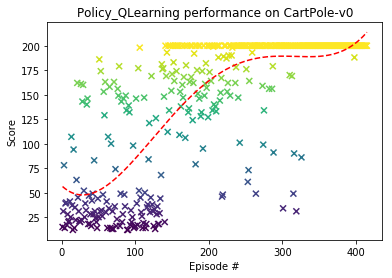

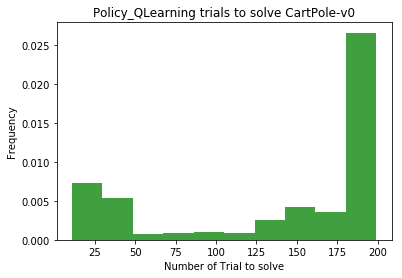

In [18]:
# Original code from https://ferdinand-muetsch.de/cartpole-with-qlearning-first-experiences-with-openai-gym.html
import math, random
# Ferdinand Mütsch ran a GridSearch on hyperparameters:
#   Best hyperparameters: 'buckets': (1, 1, 6, 12), 'min_alpha': 0.1, 'min_epsilon': 0.1

# Define a Q-Learning Policy
class Policy_QLearning():
    def __init__(self, buckets=(1, 1, 6, 12,), min_alpha=0.1, min_epsilon=0.1, gamma=1.0, ada_divisor=25, state_space_dim=4, action_space_dim=2):
        self.buckets = buckets # down-scaling feature space to discrete range
        self.min_alpha = min_alpha # Learning Rate
        self.min_epsilon = min_epsilon # Exploration Rate: # to avoid local-minima, instead of the best action, chance ε of picking a random action
        self.gamma = gamma # Discount Rate factor
        self.ada_divisor = ada_divisor # only for development purposes

        self.action_space_dim = action_space_dim
        self.Q = np.zeros(self.buckets + (self.action_space_dim,))
        self.rewards = [0]  # Initialize to 0
        self.action = 0  # Initialize to 0

    def discretize(self, obs):
        # Ferdinand choose to 
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)

    def act(self, state):
        new_state = self.discretize(state)
        self.update_q(self.current_state, self.action, self.rewards[-1], new_state, self.alpha)
        self.current_state = new_state

        if np.random.rand() <= self.epsilon:
            self.action = random.randrange(self.action_space_dim)
            return self.action
        self.action = np.argmax(self.Q[self.current_state])
        return self.action

    def memorize(self, next_state, action, reward, done):
        self.rewards.append(reward)

    def update_q(self, state_old, action, reward, state_new, alpha):
        self.Q[state_old][action] += self.alpha * '** Update the Q matrix here **'

    def reset(self, state):
        # Decrease alpha and epsilon while experimenting
        t = len(self.rewards)
        self.alpha = max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.ada_divisor)))
        self.epsilon = max(self.min_epsilon, min(1, 1.0 - math.log10((t + 1) / self.ada_divisor)))
        self.current_state = self.discretize(state)

policy = Policy_QLearning()
scores, trials_to_solve = run_cartPole(policy, n_episodes=1000, print_every=100, render_env=False)
print('** Mean average score:', np.mean(scores))
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)

The discretize function reduces the big continous observable space dimensions to _(1 * 1 * 12 * 16) =_ 72 integers.

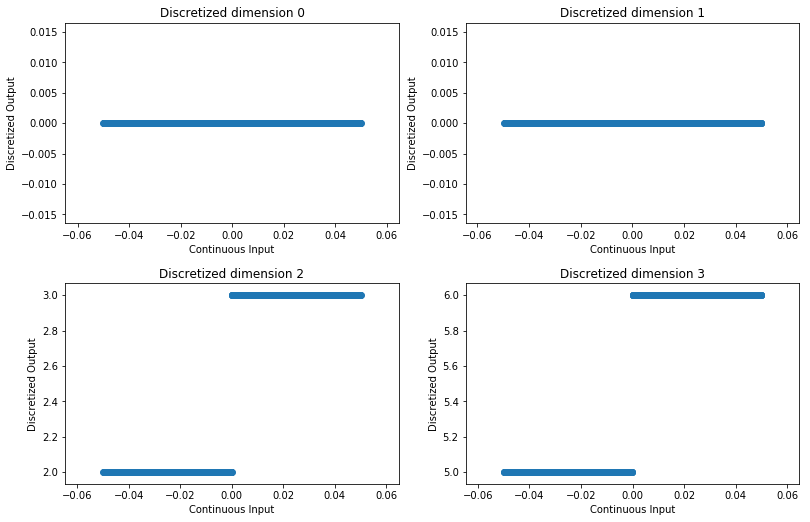

In [60]:
discretize_viz = []
for i in range(1000):
    x = env.reset()
    y = policy.discretize(x)
    discretize_viz.append(np.array([x, y]))
discretize_viz = np.array(discretize_viz)
plt.subplots_adjust(bottom=0, left=.1, right=1.8, top=1.6, hspace=.3)
i = 0

for dim_to_viz in range (4):
    plt.subplot(2, 2, i + 1)
    plt.title('Discretized dimension %d' % i)
    plt.xlabel('Continuous Input')
    plt.ylabel('Discretized Output')
    i += 1
    plt.scatter(discretize_viz[:, 0, dim_to_viz], discretize_viz[:, 1, dim_to_viz])

### 3.6 Deep Q-Learning
How to do not have to code a dimension reduction function and work on continuous state input:
- Learn a model of the monstruous Q-matrix with (Deep) Neural Networks, then infere.

#### Resources
- [Adalberto Cq DQN code](https://github.com/AdalbertoCq/Deep-Learning-Nanodegree-Udacity/blob/master/Reinforcement%20Learning/Deep%20Q-Learning%20Cart-Pole-v0/deep_q_learning_cartpole_v0.ipynb)
- [Keon Kim's Deep Q-Learning](https://keon.io/deep-q-learning/)
- [Keon Kim's Deep Q-Learning code](https://github.com/keon/deep-q-learning)
- [Ferdinand Müetsch's CartPole with a Deep Q Network](https://ferdinand-muetsch.de/cartpole-with-a-deep-q-network.html)
- [Ferdinand Müetsch's DQN code](https://gist.github.com/n1try/2a6722407117e4d668921fce53845432)


- DeepMind's Deep Q-Learning paper [Playing Atari with Deep Reinforcement Learning, _Mnih & al., NIPS 2013_](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning/)

Deep Neural Networks to model the Q Table:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_31 (Dense)             (None, 48)                1200      
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 98        
Total params: 1,418
Trainable params: 1,418
Non-trainable params: 0
_________________________________________________________________
** Evaluating Policy_DQN **
Episode 100	Average Score: 10.88	Steps: 9
Episode 200	Average Score: 9.86	Steps: 9
Episode 300	Average Score: 9.40	Steps: 10
Episode 400	Average Score: 11.37	Steps: 8
Episode 500	Average Score: 24.24	Steps: 15
Episode 600	Average Score: 41.80	Steps: 82
Episode 700	Average Score: 120.48	Steps: 199
Episode 800	Average Score: 161.75	S

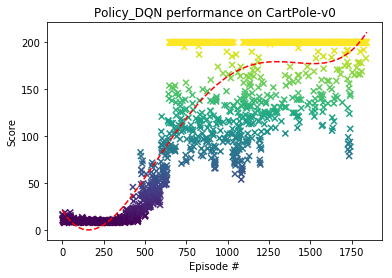

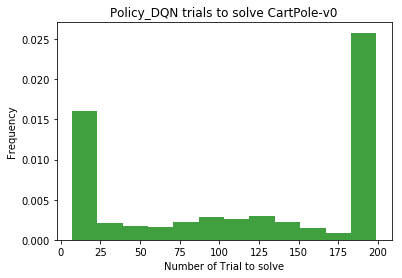

In [14]:
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Define a Deep Q-Network Agent
class Policy_DQN():
    def __init__(self, state_space_dim=4, action_space_dim=2):
        self.action_space_dim = action_space_dim
        self.gamma = 0.95  # 0.95  # Discount rate
        self.epsilon = 1.0  # 0.2 1.0<->0.1  # This should be tuned carefuly
        self.epsilon_min = 0.01  # 0.0001 0.001  
        self.epsilon_decay = 0.995  # 0.995
        self.learning_rate = 0.01  # 0.0005<->0.001  # This should be tuned carefuly
        self.learning_rate_decay = 0.01  # 0.01 Learning rate decay
        self.batch_size = 64  # 32

        self.episode = 0  # Episode counter
        self.current_state = np.array(env.reset()).reshape(1, 4)
        print('Deep Neural Networks to model the Q Table:')
        self.model = self._build_model(state_space_dim, action_space_dim)
        self.model.summary()
        # self.memory = [] 
        self.memory = deque(maxlen=100000)  # We can limit the memory size

    def _build_model(self, state_space_dim, action_space_dim):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=state_space_dim, activation='tanh'))  # 24  16  # relu  tanh
        model.add(Dense(48, activation='tanh'))  # 48 24  8  # relu  tanh
        model.add(Dense(action_space_dim, activation='linear'))  # linear
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate, decay=self.learning_rate_decay))
        return model

    def act(self, state):
        epsilon = max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((self.episode + 1) * self.epsilon_decay)))
        if np.random.random() <= epsilon:  # epsilon-greedy action selection
            # action = random.randrange(self.action_space_dim)
            action = env.action_space.sample()
        else:
            act_values = self.model.predict(np.array(state).reshape(1, 4))
            # action = np.argmax(act_values[0])
            action = np.argmax(act_values)
        return action

    def memorize(self, next_state, action, reward, done):
        # Memorize all observables and environment trial results
        next_state = np.array(next_state).reshape(1, 4)
        self.memory.append((self.current_state, action, reward, next_state, done))
        self.current_state = next_state

    def update(self, state):
        self.episode += 1  # Increment trial counter
        # Train the Q-Network
        # if len(self.memory) > self.batch_size:  # If there are enough trial in memory
        # if len(self.memory) % 4:  # Train only every 4th trial
        # if len(self.memory) > 1000:  # We can lazy start to acquire more data before learn on it
        self.replay_to_train(self.batch_size)

    def replay_to_train(self, batch_size):
        state_batch, Q_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))

        for state, action, reward, next_state, done in minibatch:
            Q_target = self.model.predict(state)  # Use the model to predict the target
            if done :  # Full reward because environment was solved
                Q_target[0][action] = reward
            else:  # Discount the reward by gamma because environment was not solved
                Q_target[0][action] = reward + self.gamma * np.max(self.model.predict(next_state)[0])

            state_batch.append(state[0])
            Q_batch.append(Q_target[0])

        self.model.fit(np.array(state_batch), np.array(Q_batch), batch_size=len(state_batch), verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


policy = Policy_DQN()

# We increase max_t so we can memorize more trials at the beginning
scores, trials_to_solve = run_cartPole(policy, n_episodes=2000, max_t=5000, print_every=100, render_env=False)

print('** Mean average score:', np.mean(scores))
plot_performance(scores)
plot_trials_to_solve(trials_to_solve)

### Going further with Deep Q-Learning
- Double DeepQ-Learning to stabilize convergence: one model predict the future state, one predict the Q-table
- Use LSTM networks as Long Term memories
- [keras-rl library](https://github.com/keras-rl/keras-rl)

# Going further
- [Neural Networks and Deep Learning book by Micheal Nielsen](http://neuralnetworksanddeeplearning.com/index.html)
- Imitation Learning: https://cdancette.fr/2018/04/09/self-driving-CNN/
- [Denny Britz excellent repository](https://github.com/dennybritz/reinforcement-learning)
- [Jonathan Hui's Reinforcement Learning overview](https://medium.com/@jonathan_hui/rl-reinforcement-learning-algorithms-quick-overview-6bf69736694d)


- What we have not see:
    - SARSA (Q-Learning generalized)
    - Temporal Difference (TD) Learning  (see Part II. [02_RL_2_CarRacing](02_RL_2_CarRacing.ipynb))
    - Cross-Entropy Method (CEM)
    - Actor-Critic, A3C
    - Deep Deterministic Policy Gradient (DDPG), Double Gradient Descent
    - Natural Policy Gradiant, TRPO, PPO, REINFORCE (Monte Carlo Policy Gradient)
    - Monte Carlo Search, Monte Carlo Tree Search (MCTS)
    - Model based: Policy Search with Gaussian Process, PILCO or Guided PS
    - Imitation Learning

## David Silver course
[Reinforcement Learning course page](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html), [Videos on YouTube](https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ)

## Richard Sutton & Andrew Barto book
[Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html)

## OpenAI docs  
- [Spinning Up in Deep RL](https://spinningup.openai.com/)  
- [Requests for Research](https://openai.com/requests-for-research/) 

## Technical hints
- [How to Parallelize Environments?](https://www.reddit.com/r/MachineLearning/comments/8aimei/d_what_is_the_right_way_to_parallelize_rollouts/)
- [Hot to Create an Environment in Gym](https://stackoverflow.com/questions/45068568/is-it-possible-to-create-a-new-gym-environment-in-openai)